# Generating radio signals

I want to be able to generate modulated digital signals such as this one...

![original radio signal](raw_data/original_radio_signal.png)

This is a binary signal coded with [On-off keying](https://en.wikipedia.org/wiki/On-off_keying) (also known as [Amplitude-shift keying](https://en.wikipedia.org/wiki/Amplitude-shift_keying)).

I'm taking the long pulses to mean "1" and the short pulses to mean "0", so this signal is transmitting the digital code, "0110100010000000".

In [2]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

## Basic wave functions

In [3]:
SAMPLE_BITSIZE = 16
MAX_AMP_16BIT = int(2**SAMPLE_BITSIZE/2 - 1)

def generate_wave(freq, len_in_sec=1, samp_rate=44100, amplitude=MAX_AMP_16BIT):
    t = np.linspace(0, len_in_sec, samp_rate * len_in_sec)
    sig = amplitude * np.sin(freq * 2 * np.pi * t) 
    return sig

def write_wav_file(file_path, wav_data, sample_rate=44100, num_channels=1):
    f = wave.open(file_path, 'wb')
    f.setparams((num_channels, 2, sample_rate, len(wav_data), "NONE", "Uncompressed"))
    f.writeframes(np.array(wav_data, dtype=np.int16))
    f.close()

def write_pcm_file(signal_data, file_path, dtype='complex64'):
    np.array(signal_data).astype(dtype).tofile(file_path)

# Amplitude modulation

First, we need to figure out how to modulate the amplitude of the carrier wave to "high amplitude" and "low amplitude" to correspond with the binary"s and 0s.

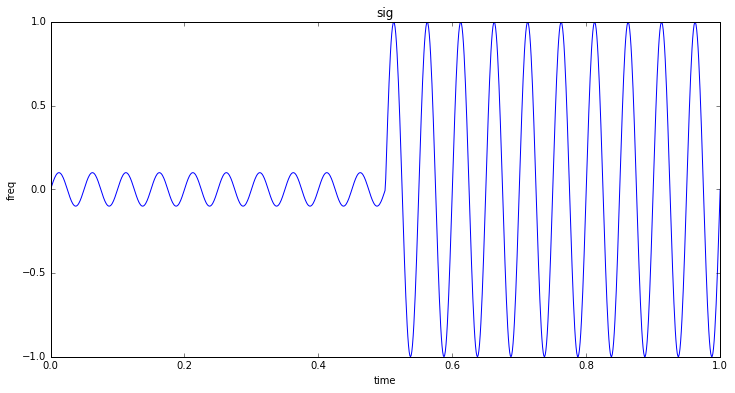

In [4]:
samp_rate = 1000
len_in_sec = 1
carrier_freq = 20

low_amp = 0.1
high_amp = 1

t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = 1*np.sin(carrier_freq * 2 * np.pi * t)

# Modulate with the binary signal: ['0', '1']
amp_mult = np.array([low_amp]*500 + [high_amp]*500)
sig = amp_mult * carrier

setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(12,6))
plt.plot(t, sig)

So looking at the above example, let's see how we calculate the size of the multiplier array...

* The carrier frequency is 20Hz.
* The baud, in this case, is 2 bits per second, which is why we need 1 second to contain the 2 bits.
* The size of the multiplier wave to modulate the carrier wave is 1000 in size because it must match the number of samples there are (which in this case, 1 second x 1000 samples per second = 1000).
* Note the width of each bit (in terms of samples) is samples_per_second / bits_per_second = 1000 / 2 = 500

## Write function to modulate amplitude according to binary data

To modulate the carrier wave signal, we will simply:
* Generate the carrier wave
* Generate a "modulation array" - an array with the LOW or HIGH amplitudes for each data point in the carrier wave array
* Multiply the "carrier wave array" with the "modulation array", to result in the "modulated signal"

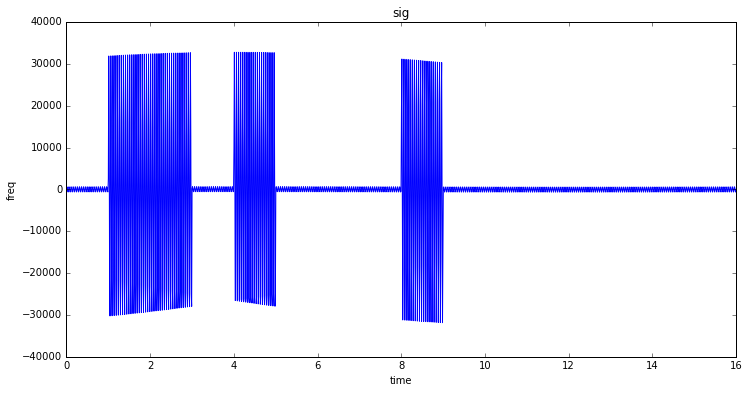

In [5]:
SAMPLE_BITSIZE = 16
MAX_AMP_16BIT = int(2**SAMPLE_BITSIZE/2 - 1)

DEFAULT_RATIOS = {
    '_': 1,
    '0': 1,
    '1': 3
}

DEFAULT_AMP_MAP = {
    '0': MAX_AMP_16BIT * .02,
    '1': MAX_AMP_16BIT
}

def get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype=np.int16):
    data_points_in_bit = int(sample_rate * 1/baud)
    modulation_array = np.array([], dtype=dtype)

    for bit in binary_data:
        bit_amplitude = amp_map[bit]
        modulated_bit = np.full(data_points_in_bit, bit_amplitude, dtype=np.int16)
        modulation_array = np.append(modulation_array, modulated_bit)
    return modulation_array

def generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate,
                               baud, sig_ratios=DEFAULT_RATIOS, amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = len(binary_data) * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    carrier_wave = 1 * np.sin(carrier_wave_freq * 2 * np.pi * t)
    modulation_array = get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype)
    return t, carrier_wave * modulation_array
    

binary_data = '0110100010000000'
carrier_wave_freq = 20 #315e6
sample_rate = 100
baud = 1

t, sig = generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud)
setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(12,6))
plt.plot(t, sig)

Sweet! So it looks like it roughly worked. But there is a problem: we have no breaks between bits (so a group of 1's looks like a single pulse). Let's fix that...

## Add the zero pulse and bit spacing

There are 2 problems with the above approach:
* Zeros should actually have a short pulse rather than LOW amplitude
* Bits should be spaced apart from each other

To accomplish this, we'll just rewrite the `get_modulation_array()` function so that each "modulated bit" will contain both the "1" or "0" pulse AND a "space" (which will simply be the LOW value).

Also, for simplicity/efficienty, we can just calculate the "1" and "0" modulation arrays once and reuse them.

I'm also going to turn up the sample rate a bit to get a more accurate signal.

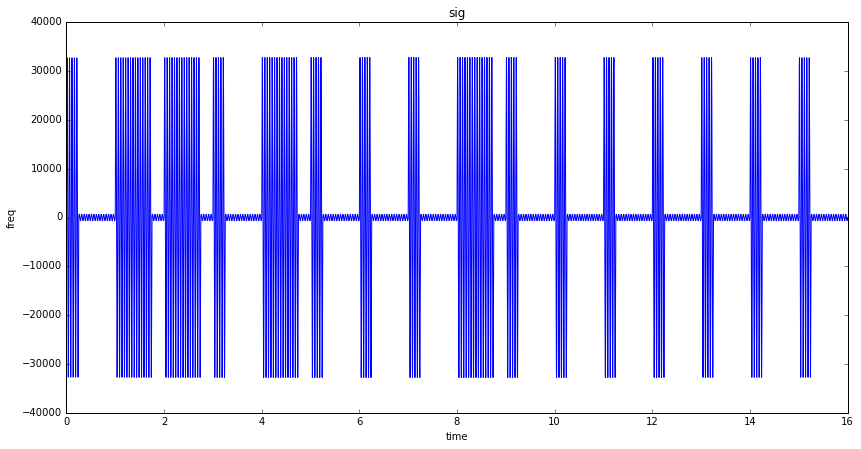

In [6]:
DEFAULT_AMP_MAP = {
    'LOW': MAX_AMP_16BIT * .02,
    'HIGH': MAX_AMP_16BIT
}

def get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype=np.int16):
    data_points_in_bit = int(sample_rate * 1/baud)
    modulation_array = np.array([], dtype=dtype)

    # To describe this general algorithms, I'll use the specific concrete pulse ratios:
    #    '_': 1,
    #    '0': 1,
    #    '1': 3
    # Meaning that a "1" should be 3x longer than a "0" or a "space" pulse. Now since we need a space
    # between "1"s (as well as "0"), we can calculate that the pulse for a "1" should be 3/4 of the bit
    # and the pulse for a "0" should be 1/4 of the bit (since for the 1, it's 3 parts "1" and 1 part "space")
    one_pulse_len = int((sig_ratios['1'] / (sig_ratios['1'] + sig_ratios['_'])) * data_points_in_bit)
    one_space_len = data_points_in_bit - one_pulse_len
    zero_pulse_len = int((sig_ratios['0'] / (sig_ratios['1'] + sig_ratios['_'])) * data_points_in_bit)
    zero_space_len = data_points_in_bit - zero_pulse_len
    
    modulated_one_bit = np.append(np.full(one_pulse_len, amp_map['HIGH'], dtype=dtype),
                                  np.full(one_space_len, amp_map['LOW'], dtype=dtype))
    modulated_zero_bit = np.append(np.full(zero_pulse_len, amp_map['HIGH'], dtype=dtype),
                                   np.full(zero_space_len, amp_map['LOW'], dtype=dtype))
    
    for bit in binary_data:
        modulated_bit = modulated_one_bit if bit == '1' else modulated_zero_bit
        modulation_array = np.append(modulation_array, modulated_bit)
    return modulation_array

def generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate,
                               baud, sig_ratios=DEFAULT_RATIOS, amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = len(binary_data) * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    carrier_wave = 1 * np.sin(carrier_wave_freq * 2 * np.pi * t)
    modulation_array = get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype)
    
    # Pad (or trim) the modulation array to match the length of the carrier wave
    if len(carrier_wave) > len(modulation_array):
        pad_len = len(carrier_wave) - len(modulation_array)
        modulation_array = np.append(modulation_array, np.full(pad_len, amp_map['LOW'], dtype=dtype))
    elif len(carrier_wave) < len(modulation_array):
        modulation_array = modulation_array[:len(carrier_wave)]
    
    return t, carrier_wave * modulation_array

binary_data = '0110100010000000'
carrier_wave_freq = 20 #315e6
sample_rate = 1000
baud = 1

t, sig = generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud)
setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(14,7))
plt.plot(t, sig)

## Looks pretty close to the original!

![original signal](raw_data/original_radio_signal.png)

## Generate real wave and write to file

In [7]:
# Estimating baud

bits_transmitted = 16
viewing_sample_rate = 100000  # samples per second
real_sample_rate = 2000000  # samples per second
viewing_transmission_time = 8.219-6.664  # seconds
real_transmission_time = viewing_transmission_time * (viewing_sample_rate / real_sample_rate)
baud = bits_transmitted / real_transmission_time # bits per second
print('Real transmission time: {}\nBaud: {}'.format(real_transmission_time, baud))

Real transmission time: 0.07774999999999999
Baud: 205.78778135048236


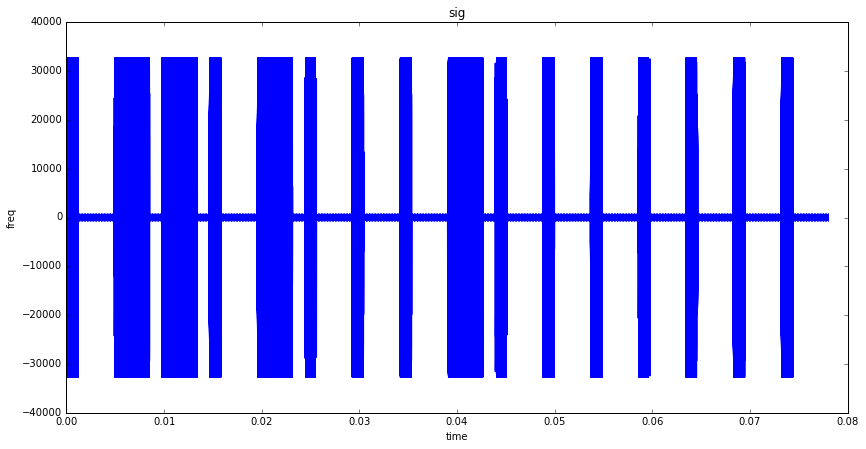

In [8]:
binary_data = '0110100010000000'
carrier_wave_freq = 315e6
sample_rate = 2e6
baud = 205

t, sig = generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud)
setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(14,7))
plt.plot(t, sig)

In [9]:
write_pcm_file(sig, 'raw_data/generated_sig1.pcm', dtype='int16')

## Now let's try to replicate the full signal

First, we need a way to generate a HIGH or LOW pulse...

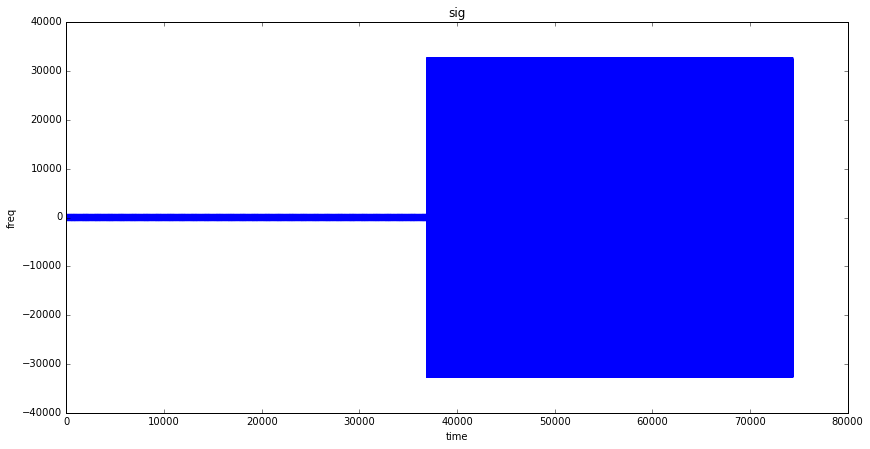

In [10]:
# Generate preamble and repeat pattern
binary_data = '0110100010000000'
carrier_wave_freq = 315e6
sample_rate = 2e6
baud = 205

def generate_pulse(bit_val, carrier_wave_freq, sample_rate, baud, multiple_of_bit_len,
                   amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = multiple_of_bit_len * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    high_or_low = 'HIGH' if bit_val == '1' else 'LOW'
    pulse = amp_map[high_or_low] * np.sin(carrier_wave_freq * 2 * np.pi * t)
    return t, pulse


t1, signal_header = generate_pulse('1', carrier_wave_freq, sample_rate, baud, 3.85)
t2, signal_spacer = generate_pulse('0', carrier_wave_freq, sample_rate, baud, 3.78)
setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(14, 7))
plt.plot(np.append(signal_spacer, signal_header))

In [11]:
def join_all_arrays(array_list):
    joined = array_list[0]
    for a in array_list[1:]:
        joined = np.append(joined, a)
    return joined

In [12]:
full_signal = join_all_arrays([signal_header] + ([sig, signal_spacer] * 12))

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


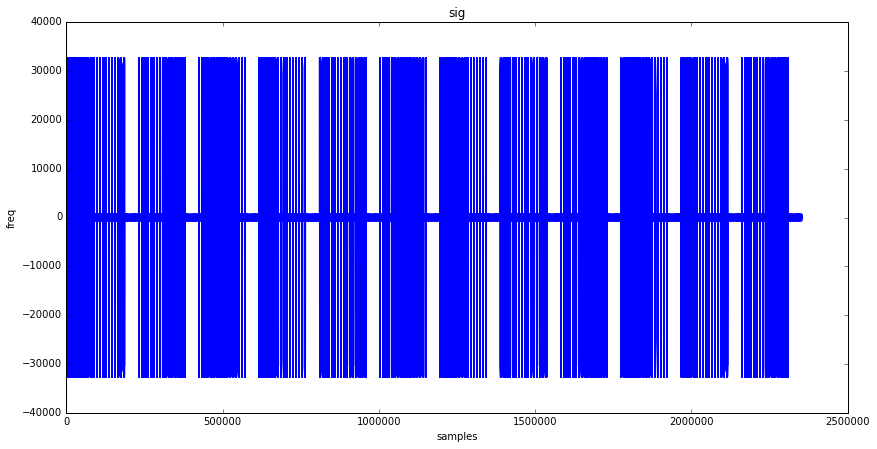

In [43]:
setup_graph(title='sig', x_label='samples', y_label='freq', fig_size=(14, 7))
plt.plot(full_signal)

In [14]:
write_pcm_file(full_signal, 'raw_data/generated_sig2.pcm', dtype='int16')

## Comparison of recorded signal vs generated signal

![comparison](raw_data/recorded_vs_generated.png)

# Complex number waves

It turns out that the HackRF only can transmit complex signals (essentially, a 2-dimensional sine wave, where time is the x axis, and the signal spins around the x axis in a helical shape that would appear like a sine wave when viewed perpendicularly).

So let's generate a complex signal...

There may be a better way, but the best way I know to generate a complex sine wave is with Euler's formula:

e^(i*t) = cos(t) + i sin(t)

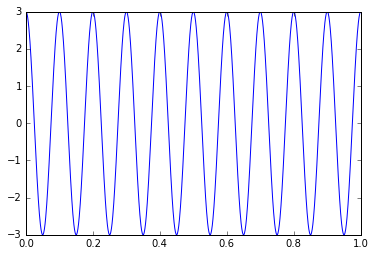

In [37]:
t = np.linspace(0, 1, 1000)
amp = 3
freq = 10 # Hz
simple_sig = amp * np.cos(freq * 2 * np.pi * t)

plt.plot(t, simple_sig)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


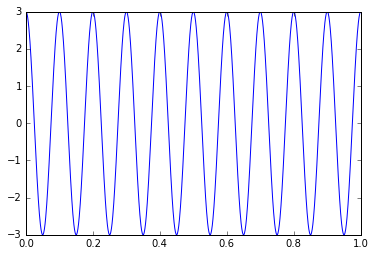

In [33]:
import cmath
complex_sig = 3 * np.e**(freq * 2 * np.pi * (0+1j) * t)
plt.plot(t, complex_sig)

In [38]:
simple_sig[5]

2.852877874620976

In [39]:
complex_sig[5]

(2.852877874620976+0.92794818416660674j)

In [36]:
abs(complex_sig[5])  # This is the amplitude of the wave

2.9999999999999996

## Now, let's rewrite the generation functions to use complex math

In [41]:
def generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate,
                               baud, sig_ratios=DEFAULT_RATIOS, amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = len(binary_data) * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    # Using Euler's formula to generate a complex sinusoidal wave
    carrier_wave = 1 * np.e**(carrier_wave_freq * 2 * np.pi * (0+1j) * t)
    modulation_array = get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype)
    
    # Pad (or trim) the modulation array to match the length of the carrier wave
    if len(carrier_wave) > len(modulation_array):
        pad_len = len(carrier_wave) - len(modulation_array)
        modulation_array = np.append(modulation_array, np.full(pad_len, amp_map['LOW'], dtype=dtype))
    elif len(carrier_wave) < len(modulation_array):
        modulation_array = modulation_array[:len(carrier_wave)]
    
    return t, carrier_wave * modulation_array

def generate_pulse(bit_val, carrier_wave_freq, sample_rate, baud, multiple_of_bit_len,
                   amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = multiple_of_bit_len * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    high_or_low = 'HIGH' if bit_val == '1' else 'LOW'
    pulse = amp_map[high_or_low] * np.e**(carrier_wave_freq * 2 * np.pi * (0+1j) * t)
    return t, pulse

In [58]:
binary_data = '0110100010000000'
carrier_wave_freq = 315e6
sample_rate = 2e6
baud = 205

complex64_amp_map = {
    'LOW': 1.4 * .02,
    'HIGH': 1.4
}

t, complex_signal = generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud, amp_map=complex64_amp_map, dtype='complex64')
t2, signal_header = generate_pulse('1', carrier_wave_freq, sample_rate, baud, 3.85, amp_map=complex64_amp_map, dtype='complex64')
t3, signal_spacer = generate_pulse('0', carrier_wave_freq, sample_rate, baud, 3.78, amp_map=complex64_amp_map, dtype='complex64')

full_signal = join_all_arrays([signal_header] + ([complex_signal, signal_spacer] * 12))

In [59]:
write_pcm_file(full_signal, 'raw_data/generated_sig2.pcm', dtype='complex64')

## Sadly, this signal did not trigger the outlet

So what's different? Well, for one, when I play the 2 signals audibly in Audacity, the original signal is pretty loud, whereas, the one I generated sounds really quiet - almost as if there is the waves I'm generating is self-canceling.

Here's a close-up of the wave I generated:

![generated zoomed in](raw_data/generated_wave_zoomedin.png)

It almost looks like ther eare equal and opposite waves that would be canceling each other out, but when you look closer, it doesn't seem so:

![generated zoomed in](raw_data/generated_wave_zoomedin2.png)

And here's a close-up of the original wave:

![original zoomed in](raw_data/original_wave_zoomedin.png)

It looks like in the original, the carrier wave is modulated by multiplying by another wave, rather than by unchanging "HIGH" values.

So I'm going to try that now: **to modulate the carrier wave by another wave**, rather than by a static HIGH value...

In [64]:
def generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate,
                               baud, sig_ratios=DEFAULT_RATIOS, amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = len(binary_data) * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    # Using Euler's formula to generate a complex sinusoidal wave
    carrier_wave = 1 * np.e**(carrier_wave_freq * 2 * np.pi * (0+1j) * t)
    modulation_array = get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype)
    
    # Pad (or trim) the modulation array to match the length of the carrier wave
    if len(carrier_wave) > len(modulation_array):
        pad_len = len(carrier_wave) - len(modulation_array)
        modulation_array = np.append(modulation_array, np.full(pad_len, amp_map['LOW'], dtype=dtype))
    elif len(carrier_wave) < len(modulation_array):
        modulation_array = modulation_array[:len(carrier_wave)]
    
    # Modulate by superwave
    super_wave_freq = carrier_wave_freq / (160*2)
    super_wave = 1 * np.e**(super_wave_freq * 2 * np.pi * (0+1j) * t)
    
    return t, carrier_wave * modulation_array * super_wave

def generate_pulse(bit_val, carrier_wave_freq, sample_rate, baud, multiple_of_bit_len,
                   amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = multiple_of_bit_len * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    high_or_low = 'HIGH' if bit_val == '1' else 'LOW'
    pulse = amp_map[high_or_low] * np.e**(carrier_wave_freq * 2 * np.pi * (0+1j) * t)
    return t, pulse

In [65]:
binary_data = '0110100010000000'
carrier_wave_freq = 315e6
sample_rate = 2e6
baud = 205 * 2

complex64_amp_map = {
    'LOW': 1.4 * .02,
    'HIGH': 1.4
}

t, complex_signal = generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud, amp_map=complex64_amp_map, dtype='complex64')
t2, signal_header = generate_pulse('1', carrier_wave_freq, sample_rate, baud, 3.85, amp_map=complex64_amp_map, dtype='complex64')
t3, signal_spacer = generate_pulse('0', carrier_wave_freq, sample_rate, baud, 3.78, amp_map=complex64_amp_map, dtype='complex64')

full_signal = join_all_arrays([signal_header] + ([complex_signal, signal_spacer] * 12))
write_pcm_file(full_signal, 'raw_data/generated_sig3.pcm', dtype='complex64')

# Success!

And this worked. I had to guess at the "super wave" frequency.

Here is what the generated signal looks like zoomed in:

![generated wave superwave](raw_data/generated_wave_superwave.png)

And here's the original signal:

![original wave superwave](raw_data/original_wave_superwave.png)

So there you have it - how to generate a digital radio signal from scratch.